**Especialización en analítica y ciencia de datos**.


**Monografía - Entrega #3**

**Grupo 11**

Autores: Jorge Luis Genes Padilla - John Byron Alzate Hernández

**Codigo utilizado para los análisis:**

In [19]:
# Importación de librerias necesarias para los diferentes análisis:

# Tratamiento de datos
import pandas as pd
import numpy as np
import statsmodels.api as sm
import math
import warnings
from google.colab import files

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

# Preprocesado y modelado
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, auc, roc_curve, precision_score,
                             recall_score, r2_score, mean_squared_error, mean_absolute_error,
                             roc_auc_score, median_absolute_error, accuracy_score)
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Configuración matplotlib
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot')

# Configuración warnings
warnings.filterwarnings('ignore')



In [2]:
# Lectura del archivo CSV que contiene la información original en estado base:
df = pd.read_csv('/bd_entrega3_entrada.csv', delimiter=';')

In [3]:
# Conversión la columna "FECHANTO" a formato de fecha y calcular la edad
df['EDAD'] = pd.Timestamp.today().year - pd.to_datetime(df.pop('FECHANTO'), format='%d/%m/%Y').dt.year

In [4]:
# Categorizar la columna "EDAD" según los nuevos rangos y categorías proporcionadas
bins = [-np.inf, 17, 29, 49, 69, np.inf]
labels = ["Underage", "Young", "Adult", "Old", "Very old"]
df['AgeCategory'] = pd.cut(df['EDAD'], bins=bins, labels=labels, right=True)

In [5]:
# Crear una variable 'Puntaje_Categorico' para categorizar la variable de salida 'PUNTAJE'
def categorize_puntaje(score):
    if 0 <= score <= 40:
        return "Bajo"
    else:
        return "Alto"

df['Puntaje_Categorico'] = df['PUNTAJE'].apply(categorize_puntaje)

In [6]:
# Eliminar la columna 'Puntaje' y eliminar registros duplicados.
df.drop('PUNTAJE', axis=1, inplace=True)
df.drop_duplicates(inplace=True)

In [7]:
# Ver los resultados de las operaciones hasta el momento
df

,COMUNA,TELEFONO,VIVIENDA,PARED,PISO,ENERGIA,ALCANTA,GAS,BASURA,ACUEDUC,...,EMBARAZA,ASISTE,TIPOESTA,GRADO,NIVEL,INGRESOS,PERCIBE,EDAD,AgeCategory,Puntaje_Categorico
0,1,1,1,2,3,1,1,2,1,1,...,1,2,0,3,1,0,1,71,Very old,Bajo
1,1,1,1,2,3,1,1,2,1,1,...,2,2,0,5,1,0,2,92,Very old,Bajo
2,1,1,1,2,3,1,1,2,1,1,...,1,2,0,5,1,0,2,86,Very old,Bajo
3,1,1,1,2,3,1,1,2,1,1,...,2,2,0,5,1,0,1,54,Old,Bajo
4,1,1,1,2,3,1,1,2,1,1,...,2,2,0,5,1,0,2,43,Adult,Bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1,1,4,3,1,1,2,1,1,...,1,2,0,5,1,60000,1,68,Old,Bajo
996,1,1,1,4,3,1,1,2,1,1,...,2,1,4,5,2,0,2,30,Adult,Bajo
997,1,1,1,1,3,1,1,2,1,1,...,2,2,0,1,2,80000,1,76,Very old,Alto
998,1,1,1,1,3,1,1,2,1,1,...,1,2,0,1,2,0,2,68,Old,Alto


In [8]:
# Obtener y ver un resumen numérico estadistico de los datos
df.describe()

,COMUNA,TELEFONO,VIVIENDA,PARED,PISO,ENERGIA,ALCANTA,GAS,BASURA,ACUEDUC,...,DISCAPA,CARNET,EMBARAZA,ASISTE,TIPOESTA,GRADO,NIVEL,INGRESOS,PERCIBE,EDAD
count,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000
mean,1.0,1.120000,1.070000,1.230000,2.682000,1.001000,1.072000,1.974000,1.0,1.013000,...,0.081000,2.822000,1.732000,1.703000,1.082000,2.807000,1.144000,9.678401e+04,1.644000,40.162000
std,0.0,0.325124,0.255275,0.878562,0.563199,0.031623,0.258617,0.159215,0.0,0.113331,...,0.672972,1.541653,0.443139,0.457165,1.745372,2.200134,0.813588,1.857429e+05,0.479055,20.137758
min,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,6.000000
25%,1.0,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.0,1.000000,...,0.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000e+00,1.000000,25.000000
50%,1.0,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,2.000000,1.0,1.000000,...,0.000000,3.000000,2.000000,2.000000,0.000000,3.000000,1.000000,0.000000e+00,2.000000,36.000000
75%,1.0,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,2.000000,1.0,1.000000,...,0.000000,4.000000,2.000000,2.000000,2.000000,5.000000,2.000000,7.625000e+04,2.000000,55.000000
max,1.0,2.000000,2.000000,7.000000,5.000000,2.000000,2.000000,2.000000,1.0,2.000000,...,7.000000,4.000000,2.000000,2.000000,6.000000,6.000000,4.000000,1.090000e+06,2.000000,99.000000


In [9]:
# Lista de columnas a convertir a tipo 'object'
columns_to_object = ['COMUNA', 'TELEFONO', 'VIVIENDA', 'PARED', 'PISO', 'ENERGIA', 'ALCANTA',
                      'GAS', 'BASURA', 'ACUEDUC', 'ESTRATO', 'ELIMBASURA', 'THOGAR', 'TENEVIV', 'USOSANI', 'USANITAR', 'DUCHA',
                      'AGUA', 'LLEGA', 'SUMINIS', 'PREPARAN', 'COCINA', 'COCINAN', 'ALUMBRA', 'USOTELE', 'NEVERA', 'LAVADORA', 'TVCOLOR', 'TVCABLE',
                      'CALENTA', 'HORNO', 'AIRE', 'COMPUTADOR', 'MOTO', 'AUTO1', 'SEXO', 'PARENTES', 'ESTCIVIL', 'CONYUVIVE', 'DISCAPA', 'CARNET', 'EMBARAZA',
                      'ASISTE', 'TIPOESTA', 'GRADO', 'NIVEL', 'PERCIBE','AgeCategory','Puntaje_Categorico']

# Cambiar las columnas a formato 'object'
df[columns_to_object] = df[columns_to_object].astype('object')


In [10]:
# Revisar el tipo de datos que existen hasta este paso en el dataframe.
df.dtypes

COMUNA                object
TELEFONO              object
VIVIENDA              object
PARED                 object
PISO                  object
ENERGIA               object
ALCANTA               object
GAS                   object
BASURA                object
ACUEDUC               object
ESTRATO               object
ELIMBASURA            object
THOGAR                object
TENEVIV               object
USOSANI               object
USANITAR              object
DUCHA                 object
AGUA                  object
LLEGA                 object
SUMINIS               object
PREPARAN              object
COCINA                object
COCINAN               object
ALUMBRA               object
USOTELE               object
NEVERA                object
LAVADORA              object
TVCOLOR               object
TVCABLE               object
CALENTA               object
HORNO                 object
AIRE                  object
COMPUTADOR            object
MOTO                  object
AUTO1         

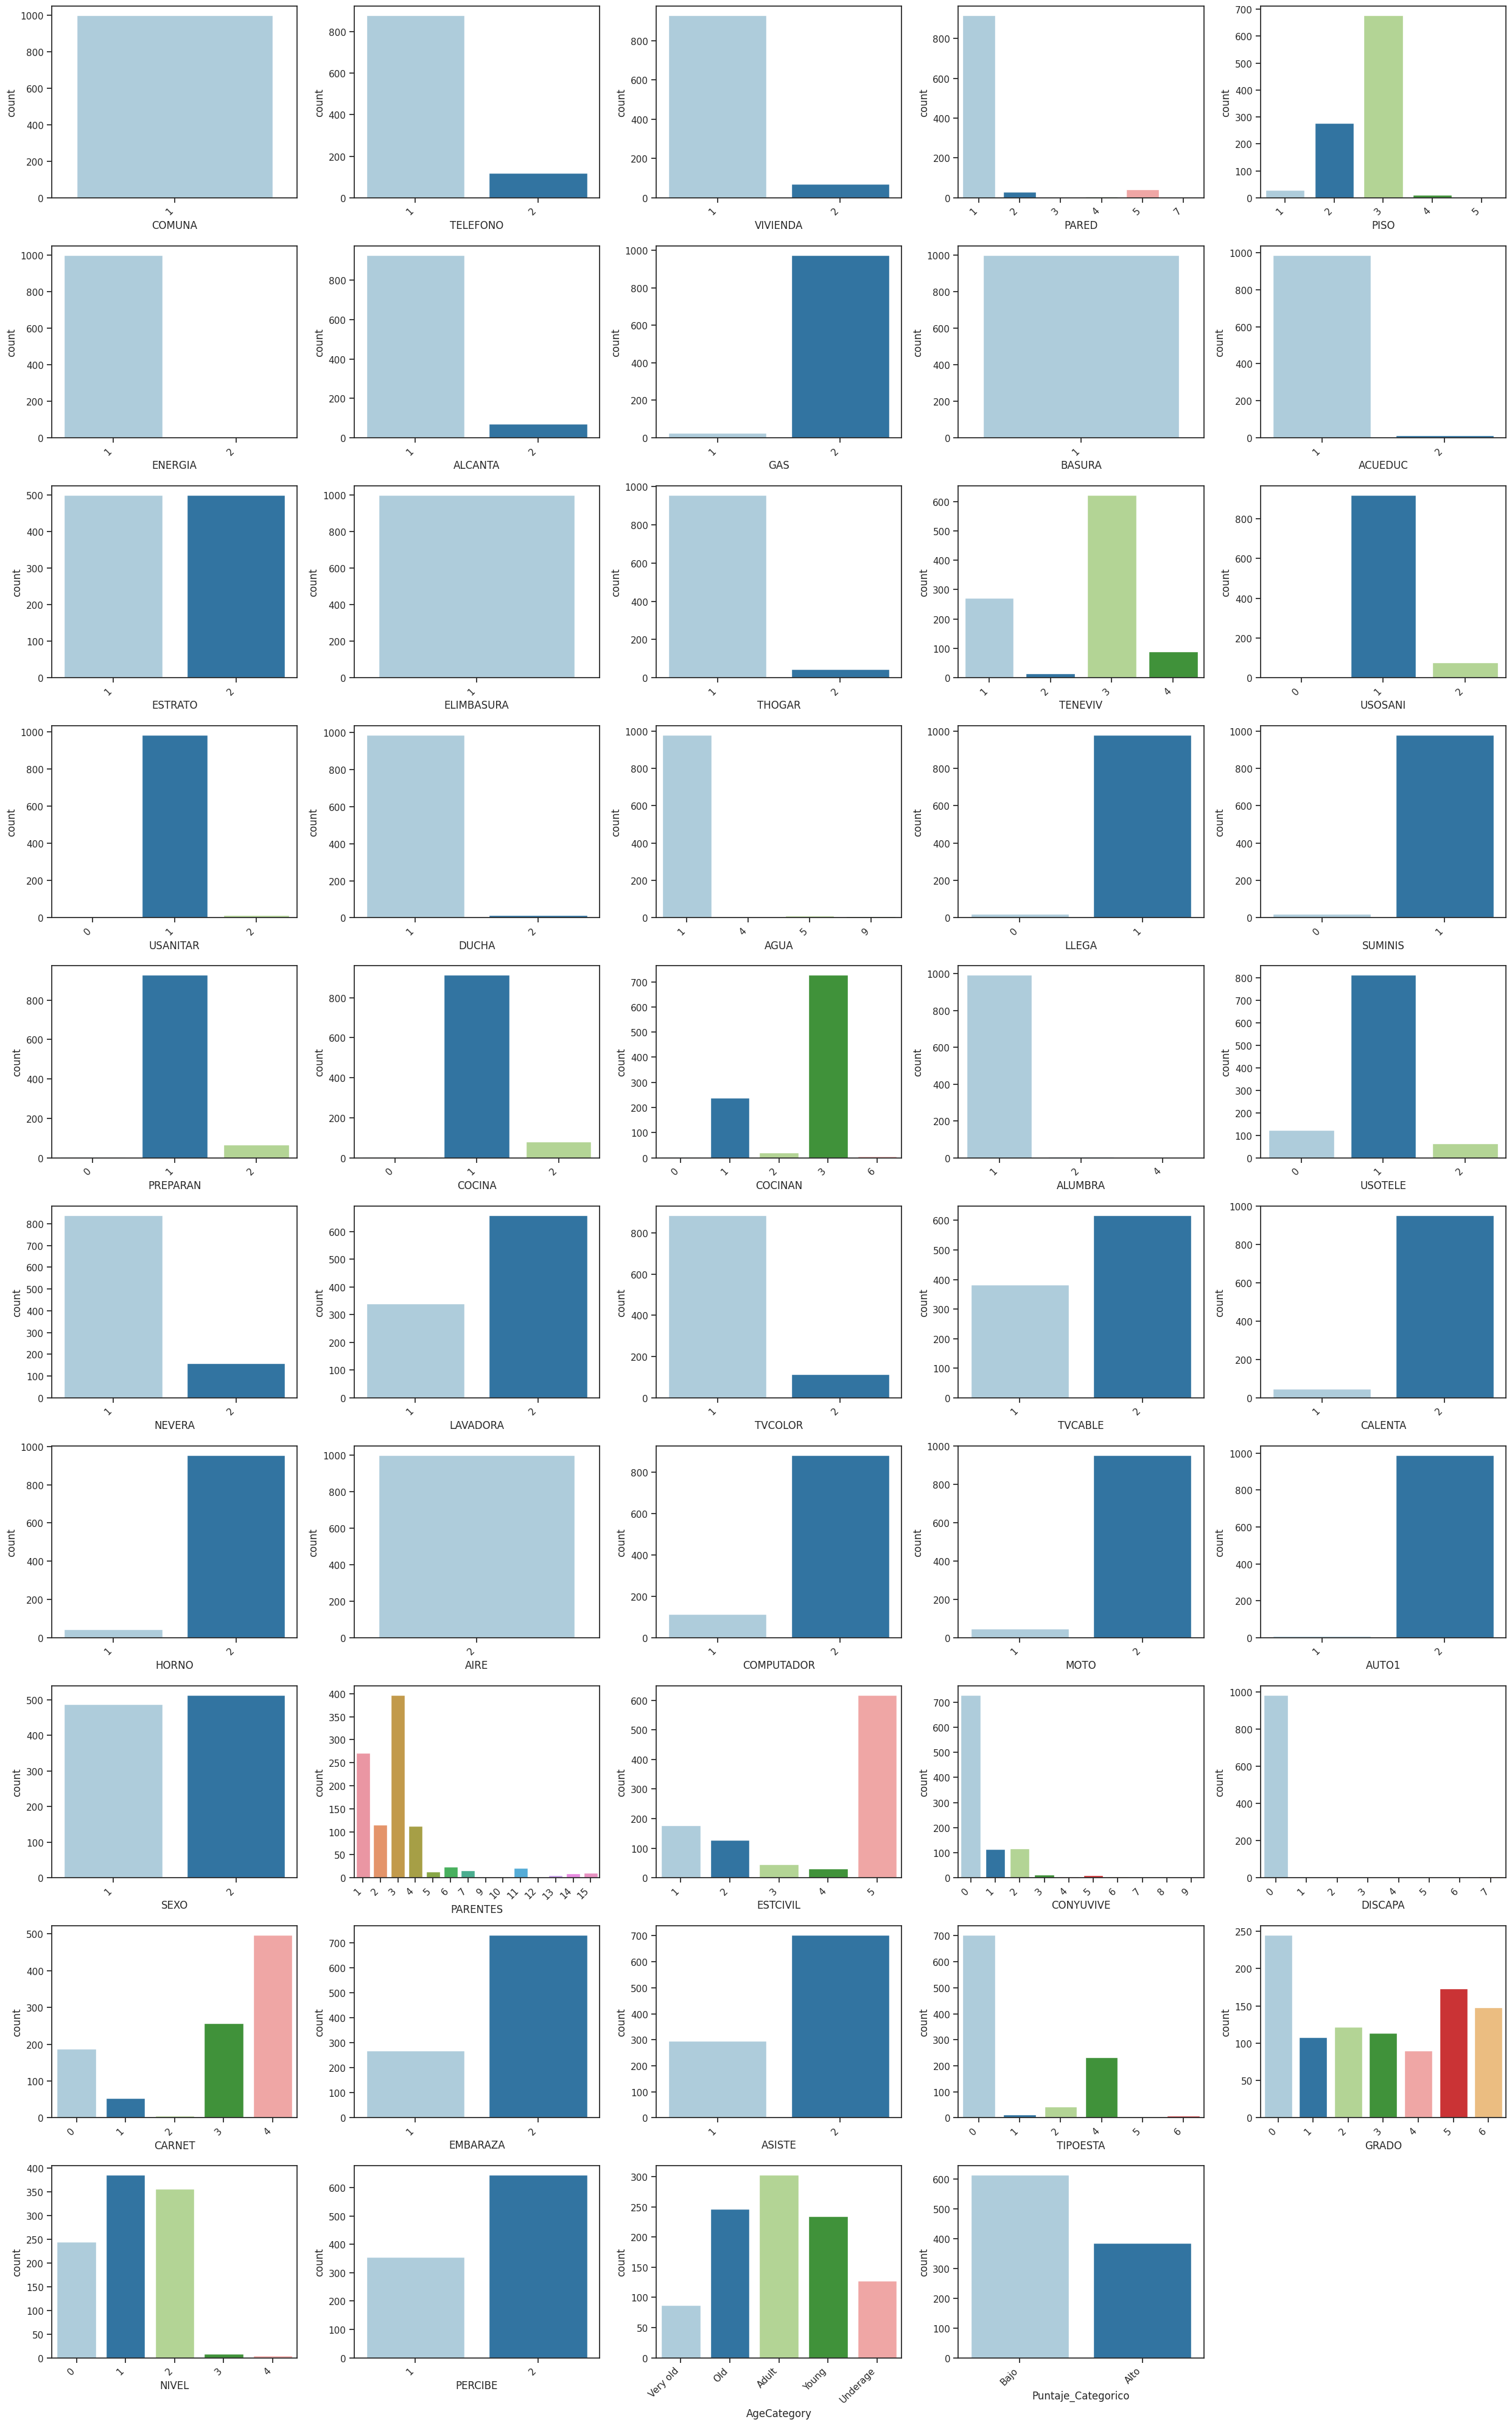

In [11]:
# Establecer las variables categóricas con la caracteristica tipo objeto
categorical_features = df.select_dtypes(include=[object])

# Establecer estilos de Seaborn
sns.set(palette='Paired', style="ticks")

# Determinar el número de filas y columnas para subgráficos
n_features = len(categorical_features.columns)
n_cols = 5
n_rows = math.ceil(n_features / n_cols)

# Realizar los gráficos de las variables categóricas
plt.figure(figsize=(25, 40), tight_layout=True)
for i, feature in enumerate(categorical_features, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.countplot(x=feature, data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

In [12]:
# Definición para convertir columna 'INGRESOS' a tipo 'float64'
columns_to_number = ['INGRESOS']
df[columns_to_number] = df[columns_to_number].astype('float64')


In [13]:
# Revisar el tipo de datos que existen hasta este paso en el dataframe.
df.dtypes

COMUNA                 object
TELEFONO               object
VIVIENDA               object
PARED                  object
PISO                   object
ENERGIA                object
ALCANTA                object
GAS                    object
BASURA                 object
ACUEDUC                object
ESTRATO                object
ELIMBASURA             object
THOGAR                 object
TENEVIV                object
USOSANI                object
USANITAR               object
DUCHA                  object
AGUA                   object
LLEGA                  object
SUMINIS                object
PREPARAN               object
COCINA                 object
COCINAN                object
ALUMBRA                object
USOTELE                object
NEVERA                 object
LAVADORA               object
TVCOLOR                object
TVCABLE                object
CALENTA                object
HORNO                  object
AIRE                   object
COMPUTADOR             object
MOTO      

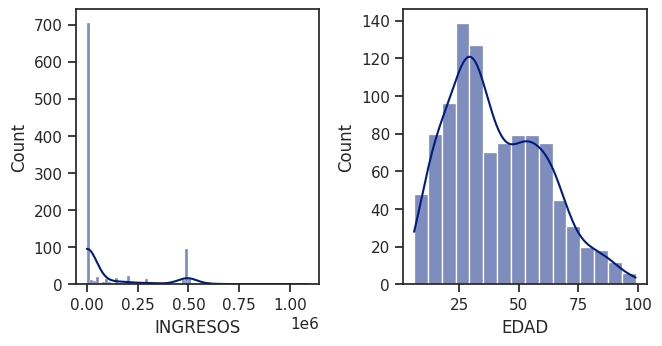

In [14]:
# Establecer las variables numéricas del dataset
numeric_features = df.select_dtypes(include=[np.number])

# Establecer estilos de Seaborn
sns.set(palette='dark', style="ticks")

# Configurar el número de filas y columnas para subgráficos en 2x2
n_cols = 3
n_rows = 3

# Graficar las variables numéricas del dataset
plt.figure(figsize=(10, 10), tight_layout=True)  # Ajustar el tamaño de la figura
for i, feature in enumerate(numeric_features.columns, 1):
    if i > 5:  # Solo mostrar 4 gráficas
        break
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[feature], kde=True)
    plt.xlabel(feature)
    plt.ylabel("Count")

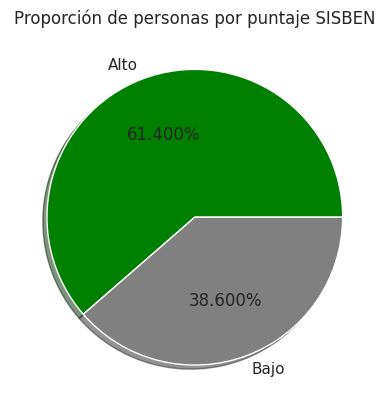

In [15]:
# Realizar el conteo del número de registros de la variable 'Puntaje_Categorico' y graficarlos en una gráfica de torta.
plt.pie(x = df['Puntaje_Categorico'].value_counts() ,autopct='%1.3f%%' ,labels=['Alto', 'Bajo'], colors=['green', 'gray'], shadow=True)
plt.title('Proporción de personas por puntaje SISBEN')
plt.show()


In [17]:
# Hacer llamado a la funcionalidad de Label encoder para clasificación categórica
le = LabelEncoder()

# Obtener una lista de nombres de columnas categóricas
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Generar variables dummies de las columnas categoricas
for col in categorical_cols:
    if len(df[col].unique()) <= 2:
        df[col] = le.fit_transform(df[col])
    else:
        df = pd.get_dummies(df, columns=[col], drop_first=True)

In [18]:
# Ver el resultado final de las transformaciones del dataset
df.head()

,COMUNA,TELEFONO,VIVIENDA,ENERGIA,ALCANTA,GAS,BASURA,ACUEDUC,ESTRATO,ELIMBASURA,...,GRADO_5,GRADO_6,NIVEL_1,NIVEL_2,NIVEL_3,NIVEL_4,AgeCategory_Old,AgeCategory_Underage,AgeCategory_Very old,AgeCategory_Young
0,0,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


**La anterior tabla es el resultado final de las transformaciones de datos con las cuales operaremos en pasos y entregas posteriores en cuanto a modelos de ML. Con dicha tabla se cumple el alcance de la entrega #3 de la asignatura Seminario.**

In [20]:
# Guardar el DataFrame en un archivo CSV
df.to_csv('bd_entrega3_salida.csv', index=False)  # index=False para no incluir el índice en el archivo

# Descargar el archivo CSV a tu máquina local
files.download('bd_entrega3_salida.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>